In [ ]:
!pip install yfinance tensorflow scikit-learn matplotlib


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.losses import MeanSquaredError
import time
from IPython.display import clear_output


In [ ]:
def build_model(time_steps=60):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(df[['Close']])
    X, y = [], []
    for i in range(time_steps, len(scaled)):
        X.append(scaled[i-time_steps:i, 0])
        y.append(scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler


In [ ]:
STOCK = "AAPL"
PERIOD = "1y"
INTERVAL = "1h"
TIME_STEPS = 60

df = yf.download(STOCK, period=PERIOD, interval=INTERVAL)
df = df[['Close']]

X_train, y_train, scaler = prepare_data(df, TIME_STEPS)

model = build_model(TIME_STEPS)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
model.save("/content/stock_lstm_model.h5")


/tmp/ipython-input-199530457.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(STOCK, period=PERIOD, interval=INTERVAL)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.1184
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0059
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0043
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0038
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0035
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0032
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0031
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0025
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0027
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0023


In [ ]:
def live_predict(stocks, model_path="/content/stock_lstm_model.h5", time_steps=60, interval="1h"):
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
    scalers = {}

    while True:
        try:
            clear_output(wait=True)
            fig, axes = plt.subplots(len(stocks), 1, figsize=(10, 4*len(stocks)))
            if len(stocks) == 1:
                axes = [axes]

            for i, stock in enumerate(stocks):
                df_live = yf.download(stock, period='3mo', interval=interval, progress=False)
                if df_live.empty or len(df_live) < time_steps:
                    axes[i].text(0.5, 0.5, "Not enough data", ha='center', va='center')
                    continue

                df_live = df_live[['Close']]

                # Fit scaler
                if stock not in scalers:
                    scalers[stock] = MinMaxScaler(feature_range=(0,1))
                    scalers[stock].fit(df_live[['Close']])

                latest_data = df_live[['Close']].values[-time_steps:]
                scaled = scalers[stock].transform(latest_data)
                X_live = np.reshape(scaled, (1, time_steps, 1))

                pred_scaled = model.predict(X_live)
                pred_price = scalers[stock].inverse_transform(pred_scaled)[0][0]

                last_real = float(df_live['Close'].iloc[-1])
                pred_price = float(pred_price)

                axes[i].plot(df_live['Close'].values, label=f"{stock} Actual", color='cyan')
                axes[i].axhline(pred_price, color='red', linestyle='--', label=f"Predicted: {pred_price:.2f}")
                axes[i].set_title(f"{stock} | Real: {last_real:.2f} | Predicted: {pred_price:.2f}")
                axes[i].legend()


            plt.tight_layout()
            plt.show()
            print(f"🔄 Updated predictions at {time.strftime('%H:%M:%S')}")
            time.sleep(60)

        except Exception as e:
            print("⚠️ Error:", e)
            time.sleep(60)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


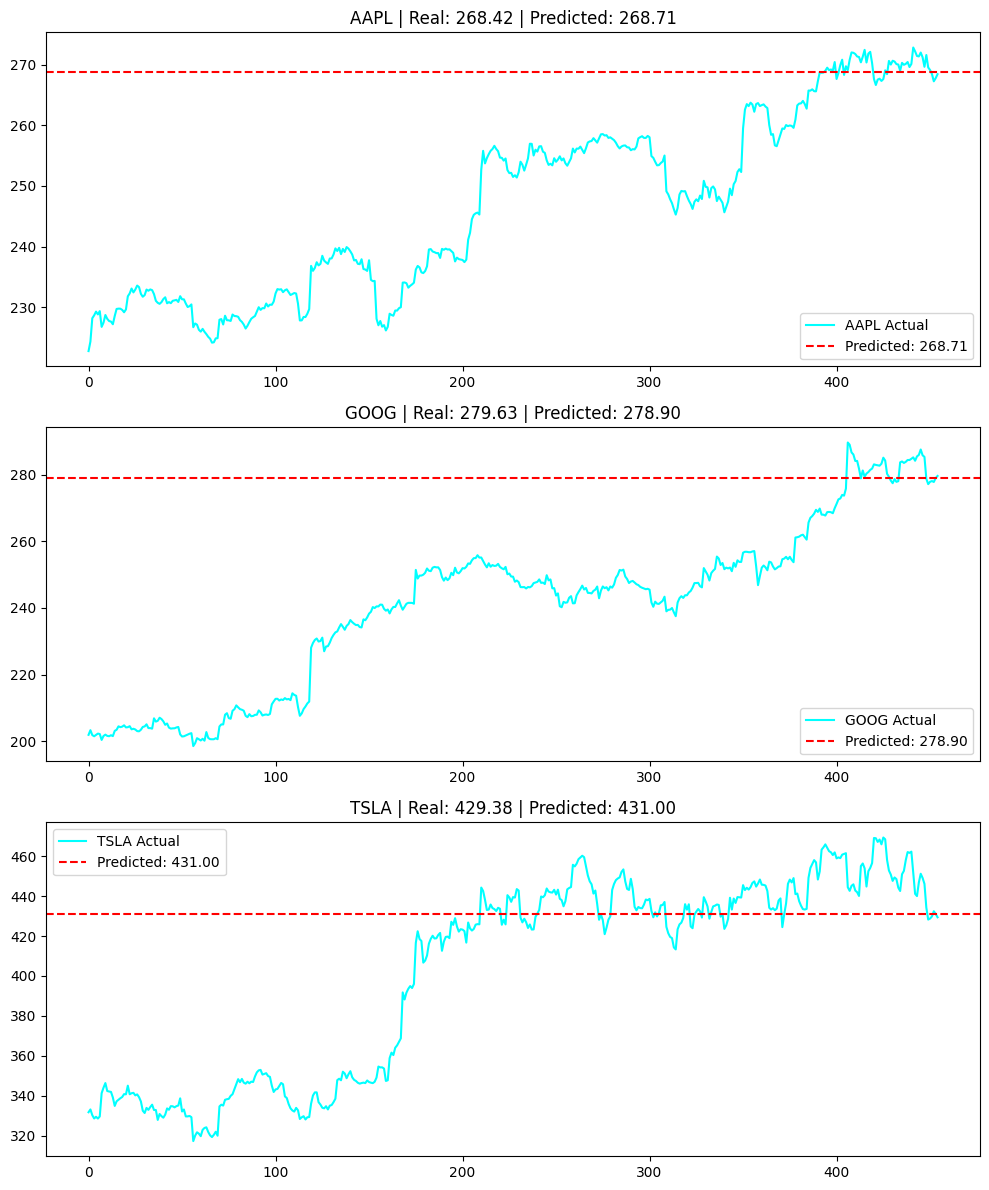

🔄 Updated predictions at 11:05:01


In [ ]:
import warnings
warnings.filterwarnings("ignore")

stocks = ["AAPL", "GOOG", "TSLA"]  # add more if you want
live_predict(stocks)
